<a href="https://colab.research.google.com/github/tbeucler/2023_SD_REP/blob/main/Figures_Tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We designed this notebook so that it can be run in Google Colab. To prepare the data, **please upload `RV_Zip_Count.csv`and `Spatial_Join_SVI.dbf` in "Files"**.  

We will install the required Python libraries, pre-process the data, then calculate simple statistics, and finally reproduce the study's figures.

# Python Libraries Installation and Import

In [7]:
#@title Install the required libraries (we specify the version to facilitate reproducibility)
!pip install pandas==1.5.3
!pip install simpledbf==0.2.6
!pip install numpy==1.23.0
!pip install matplotlib==3.7.2
!pip install seaborn==0.12.2

In [8]:
#@title Import the required libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np

import pandas as pd

import seaborn as sns
import simpledbf
from simpledbf import Dbf5

In [9]:
#@title Change font type to match JAMA style

# Font properties
plt.rcParams['font.size'] = 12

In [10]:
#@title Load the TTF Times New Roman font files and set as default font
font_paths = {
    'regular': '/content/times.ttf',
    'bold': '/content/timesbd.ttf',
    'italic': '/content/timesi.ttf',
    'bold_italic': '/content/timesbi.ttf',
}

font_props = {
    'regular': fm.FontProperties(fname=font_paths['regular']),
    'bold': fm.FontProperties(fname=font_paths['bold']),
    'italic': fm.FontProperties(fname=font_paths['italic']),
    'bold_italic': fm.FontProperties(fname=font_paths['bold_italic']),
}

# Register the fonts with Matplotlib
font_manager = fm.FontManager()
for font_style, font_prop in font_props.items():
    font_manager.ttflist.append(font_prop)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Data Pre-Processing

## Calculate the drop in Week 10-15 respiratory visits between 2016-2019 and 2020 per San Diego zipcode

In [11]:
# Read the data from a CSV file
rv_zip_count = pd.read_csv('RV_Zip_Count.csv')

In [12]:
# Duplicate rv_zip_count, but only keep 'week_of_year' from 10 to 15
rv_zip_count_week_10_15 = rv_zip_count[rv_zip_count['week_of_year'].isin([10, 11, 12, 13, 14, 15])]

In [13]:
# Per zip code and per year, sum all the patients from 'week_of_year' from 10 to 15
rv_zip_sum_week_10_15 = rv_zip_count_week_10_15.groupby(['zip', 'year'])['Number of patients'].sum().reset_index()

In [14]:
# Now average all years together except 2020
# Average all years together except 2020
diff = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] != 2020]
diff = (diff.groupby('zip')['Number of patients'].sum()/4).reset_index()

In [15]:
# Replace the name of the column "Number of patients" with "2016-2019" in diff
diff.rename(columns={'Number of patients': '2016-2019'}, inplace=True)

In [16]:
# Extract the number of patients in 2020 from rv_zip_sum_week_10_15
rv_zip_2020 = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] == 2020]

In [17]:
# Loop over zipcodes in diff to merge the 2016-2019 & 2020 visits in the same structure
# If the zipcode is in rv_zip_2020, assign rv_zip_2020['Number of patients'] to diff['2020']
for index, row in diff.iterrows():
  if row['zip'] in rv_zip_2020['zip'].values:
    diff.loc[index, '2020'] = rv_zip_2020.loc[rv_zip_2020['zip'] == row['zip']]['Number of patients'].values[0]
  else: diff.loc[index, '2020'] = 0.0

In [18]:
# Subtract the number of patients in diff from the number of patients in rv_zip_2020
# Divide weeks 10-15 by 6 to get weekly drop in pediatric respiratory visits
diff['six-week-diff'] = (diff['2020'] - diff['2016-2019'])
diff['drop_in_patients'] = -diff['six-week-diff']/6 # Per week
diff['relative_drop'] = -100*diff['six-week-diff']/diff['2016-2019'] # In % with respect to 2016-2019 average

In [19]:
# Only keep San Diego zipcodes
# Delete all rows corresponding to 'zip' greater than 92199 and smaller than 91901
diff = diff[(diff['zip'] <= 92199) & (diff['zip'] >= 91901)]

In [20]:
diff

,zip,2016-2019,2020,six-week-diff,drop_in_patients,relative_drop
149,91901,9.75,8.0,-1.75,0.291667,17.948718
150,91902,10.25,5.0,-5.25,0.875000,51.219512
151,91903,0.50,0.0,-0.50,0.083333,100.000000
152,91905,1.25,0.0,-1.25,0.208333,100.000000
153,91906,4.50,4.0,-0.50,0.083333,11.111111
...,...,...,...,...,...,...
273,92177,0.25,1.0,0.75,-0.125000,-300.000000
274,92178,0.25,1.0,0.75,-0.125000,-300.000000
275,92192,0.50,0.0,-0.50,0.083333,100.000000
276,92196,0.25,0.0,-0.25,0.041667,100.000000


## Pre-Process database containing spatially-joined zipcodes and CDC social vulnerability indices

In [21]:
# Path to the spatially-joined zipcode and SVIs
path_dbf = '/content/Spatial_Join_Zip_SVI.dbf'

In [22]:
dbf = Dbf5(path_dbf) # Load dbf file
svi = dbf.to_dataframe() # Convert to pd dataframe
svi['zip'] = svi['zip'].astype('int') # Convert zipcodes to integers
svi = svi.replace(-999, np.nan) # Replace -999 values with NaN following CDC conventions

In [23]:
# Group SVI statistics by zip code
svi_zip = {}
svi_zip['zipcode'] = svi.groupby('zip')['zip'].unique().astype('int')

svi_zip['all_mean'] = svi.groupby('zip')['RPL_THEMES'].mean()
svi_zip['socioeconomic_mean'] = svi.groupby('zip')['RPL_THEME1'].mean()
svi_zip['household_mean'] = svi.groupby('zip')['RPL_THEME2'].mean()
svi_zip['minority_mean'] = svi.groupby('zip')['RPL_THEME3'].mean()
svi_zip['housing_mean'] = svi.groupby('zip')['RPL_THEME4'].mean()

svi_zip['all_min'] = svi.groupby('zip')['RPL_THEMES'].min()
svi_zip['socioeconomic_min'] = svi.groupby('zip')['RPL_THEME1'].min()
svi_zip['household_min'] = svi.groupby('zip')['RPL_THEME2'].min()
svi_zip['minority_min'] = svi.groupby('zip')['RPL_THEME3'].min()
svi_zip['housing_min'] = svi.groupby('zip')['RPL_THEME4'].min()

svi_zip['all_max'] = svi.groupby('zip')['RPL_THEMES'].max()
svi_zip['socioeconomic_max'] = svi.groupby('zip')['RPL_THEME1'].max()
svi_zip['household_max'] = svi.groupby('zip')['RPL_THEME2'].max()
svi_zip['minority_max'] = svi.groupby('zip')['RPL_THEME3'].max()
svi_zip['housing_max'] = svi.groupby('zip')['RPL_THEME4'].max()

In [24]:
# Convert svi_zip to a pandas dataframe
svi_zip = pd.DataFrame(svi_zip)

## Link mean weekly drop in respiratory visits to CDC social vulnerability indices

In [25]:
# Merge diff with svi_zip based on 'zip'
svi_zip_diff = svi_zip.merge(diff, on='zip')

# Zipcode-Based Statistics

First, we have to design a population-weighting scheme to avoid giving too much weight to zipcodes that have very few patients over the 2016-2020 periods. To do this, we will weigh our correlations by 2016-2019 average patient population over the six weeks of interest (10-15).

In [26]:
#@title Weighted mean, covariance, and Pearson correlation functions
# From https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def w_m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def w_cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - w_m(x, w)) * (y - w_m(y, w))) / np.sum(w)

def w_corr(x, y, w):
    """Weighted Correlation"""
    return w_cov(x, y, w) / np.sqrt(w_cov(x, x, w) * w_cov(y, y, w))

In [114]:
#@title Weighted Pearson correlation of `key_interest` with all keys in the dictionary
def w_corr_dic(dic, key_interest, weighting_key=None, keys_to_exclude=None):
  w_corr_dic = {} # Initialize the dictionary
  # Make a copy of dic.keys() and then exclude all the items in key_to_exclude from it
  filtered_keys = {key: dic[key] for key in dic if key not in keys_to_exclude}
  # Calculate weighted correlations; use uniform weightining if w_key argument is None
  for key in filtered_keys:
    if weighting_key:
      w_corr_dic[key] = w_corr(dic[key_interest], dic[key], dic[weighting_key])
    else:
      w_corr_dic[key] = w_corr(dic[key_interest], dic[key], dic[key_interest]**0)

  return w_corr_dic

In [28]:
#@title Plotting routines for correlations
def plot_correlations(correlation_dictionary, **kwargs):
  fig,ax = plt.subplots(figsize=(12.5,5))
  # Sort correlations
  cor_sorted = sorted(correlation_dictionary.items(), key=lambda x: x[1])
  # extract labels and values
  labels = [value[0] for value in cor_sorted]
  values = [value[1] for value in cor_sorted]

  # create a horizontal bar plot
  plt.barh(labels, values)

  # add labels and title
  title_0 = 'Correlations'
  for key, value in kwargs.items():
    title_0 += ' '; title_0 += value;
  plt.xlabel('Pearson correlation')
  plt.title(title_0)

  return fig,ax

## Correlation bar plots

Use the short call below to plot the correlation of any key with respect to other keys, using the key you would like to weigh the statistics (use `weighting_key= None` for no weighting).

In [29]:
# Print available keys
print(svi_zip_diff.keys())

Index(['zip', 'zipcode', 'all_mean', 'socioeconomic_mean', 'household_mean',
       'minority_mean', 'housing_mean', 'all_min', 'socioeconomic_min',
       'household_min', 'minority_min', 'housing_min', 'all_max',
       'socioeconomic_max', 'household_max', 'minority_max', 'housing_max',
       '2016-2019', '2020', 'six-week-diff', 'drop_in_patients',
       'relative_drop'],
      dtype='object')


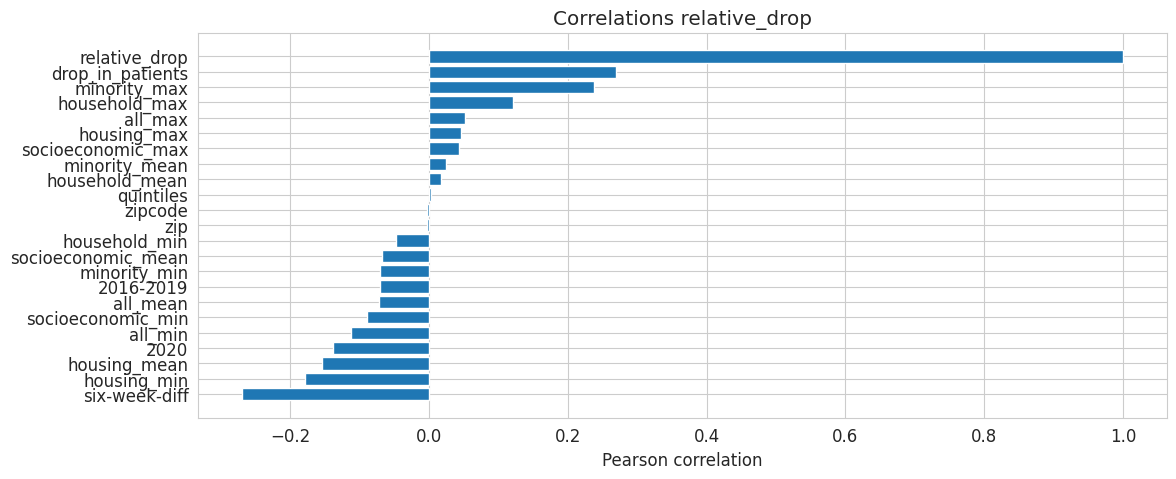

In [45]:
key_interest = 'relative_drop' # Key of interest for correlations

plot_correlations(w_corr_dic(dic = svi_zip_diff,
                             key_interest = key_interest,
                             weighting_key= None),
                  title = key_interest);

### Stratified box and correlation plots to control for confounding variables

In [121]:
#@title Function to output box/correlation plots of a variable of interest, with the data stratified using a potentially confounding variable
def stratified_plot(dic, key_stratification, key_interest, n_folds=5, **kwargs):
  '''
  dic: Dictionary containing the data
  key_stratification: Key used to stratify the data
  key_interest: Key of interest for the study
  n_folds: Number of stratification folds
  '''
  # Divide rows of dic into n_folds folds of dic[key_stratification]
  folds = pd.qcut(dic[key_stratification], q=n_folds, labels=False)
  dic['folds'] = folds

  # Extract min and max of each quintile group
  folds_min = dic.groupby('folds')[key_stratification].min()
  folds_max = dic.groupby('folds')[key_stratification].max()
  # Use it to create labels describing the range for each quintile
  folds_labels = [str(folds_min[i])[:(n_folds-1)]+'-'\
                  +str(folds_max[i])[:(n_folds-1)] for i in range(n_folds)]

  fig,ax = plt.subplots(n_folds+1, 1, figsize=(10,7.5*(n_folds+1)))

  # Box plot of key_interest stratified using key_stratification
  sns.boxplot(x = 'folds', y = key_interest, data = dic,
              notch=True, ax=ax[0])
  # Polish the plot
  ax[0].set_title(key_interest + ' stratified using ' + str(n_folds) + \
                  ' quantiles of ' + key_stratification, fontsize=14)
  ax[0].set_xlabel(str(n_folds)+" quantiles of "+key_stratification)
  ax[0].set_ylabel(key_interest)
  # Set style
  sns.set_style("whitegrid")
  ax[0].set_xticklabels(folds_labels)
  ax[0].tick_params(axis='x', rotation=30)

  # Correlation plot of key_interest inside each key_stratification fold
  for iax in range(n_folds):
    corr_dic = w_corr_dic(dic = dic[dic['folds'] == iax].copy(),
                          key_interest = key_interest,
                          weighting_key = None, keys_to_exclude = ['folds']);
    # Sort correlations
    cor_sorted = sorted(corr_dic.items(), key=lambda x: x[1])
    # extract labels and values
    labels = [value[0] for value in cor_sorted]
    values = [value[1] for value in cor_sorted]
    # create a horizontal bar plot
    ax[iax+1].barh(labels, values)
    # add labels and titles
    ax[iax+1].set_title('Correlations for ' + key_interest + ' in fold ' + \
                        str(iax+1) + ' of variable ' + key_stratification)
    ax[iax+1].set_xlabel('Pearson correlation')

  return fig,ax

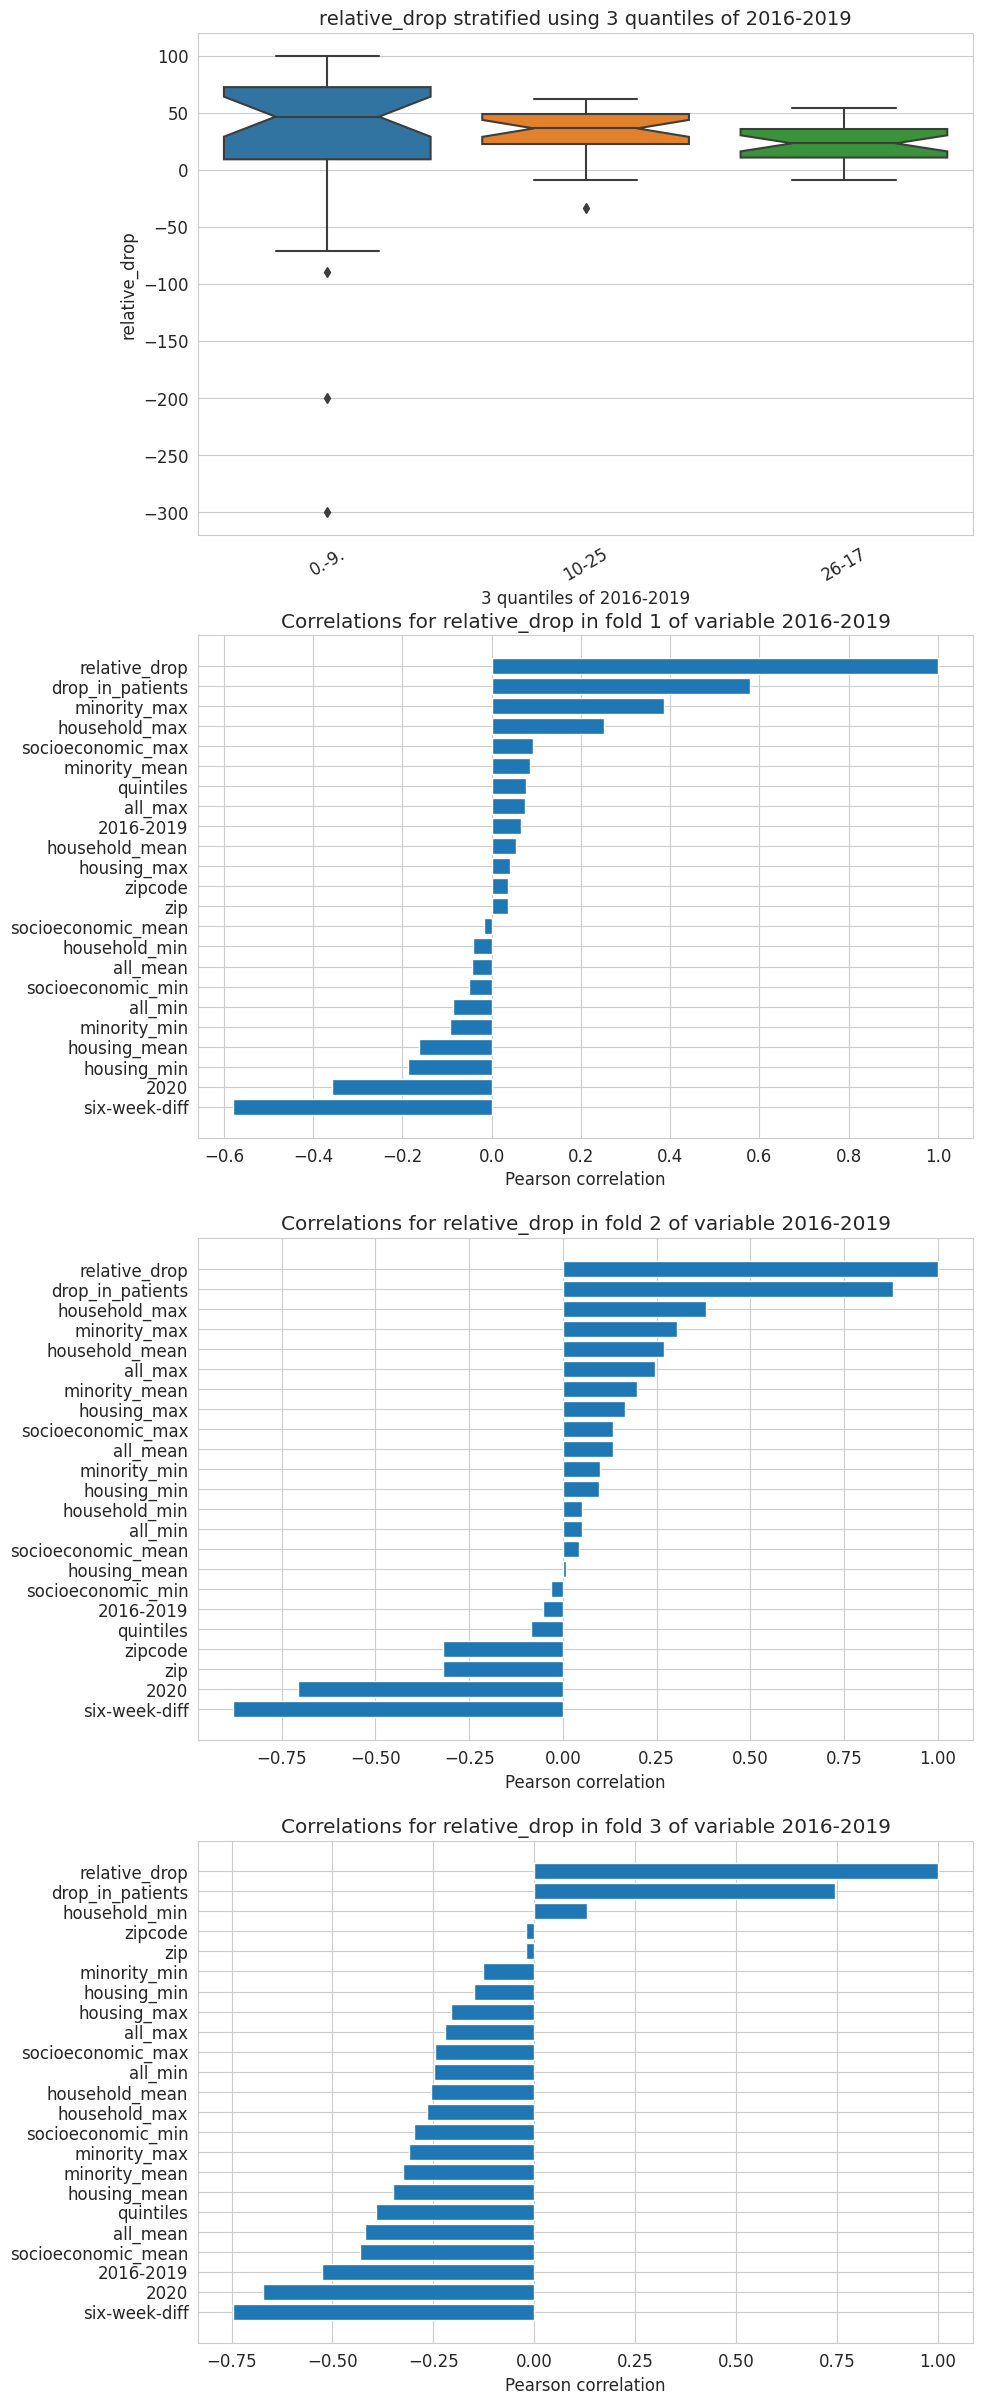

In [122]:
stratified_plot(svi_zip_diff, '2016-2019', 'relative_drop', n_folds=3);